In [ ]:
import dill as pickle
import numpy as np 
from ChangeOfMind.functions import processing as proc
from controllers import utils as ut
import os
from pathlib import Path
from scipy.io import loadmat, savemat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import ssm
import numpy as np, random
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d as gf
from sklearn.metrics import silhouette_score, davies_bouldin_score


/Users/assiachericoni/miniforge3/envs/ControllerPacman/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kwargs = {}
kwargs['smoothing'] = 80
kwargs['d_hpc']=3
kwargs['kmeans_hpc']= 2 #4
kwargs['d_acc']=3
kwargs['d_ofc']=3
kwargs['kmeans_acc']= 3 #5
kwargs['kmeans_ofc']= 3 #5
kwargs['ncomps_sep']=0
kwargs['prewin_behave'] = 14  # Specifies behavioral data window, extend for delayed GLM
kwargs['behavewin_behave'] = 15  # specifies post event behavioral window
kwargs['all_subjects'] = False
kwargs['plottype'] = 'ldscluster'
kwargs['return_type'] = 'save'
kwargs['dowhiten'] = True


cfgparams = {}
cfgparams['locking'] = 'onset'  # 'zero
cfgparams['keepamount'] = 12
cfgparams['dt_ms'] = 16.67
cfgparams['win_ms'] = 80

cfgparams['timewarp'] = {}
if 'prewin' in kwargs:
    cfgparams['prewin'] = kwargs['prewin']
else:
    cfgparams['prewin'] = 14
if 'behavewin' in kwargs:
    cfgparams['behavewin'] = kwargs['behavewin']
else:
    cfgparams['behavewin'] = 15

if 'prewin_behave' in kwargs:
    cfgparams['prewin_behave'] = kwargs['prewin_behave']
else:
    cfgparams['prewin_behave'] = 14

if 'behavewin_behave' in kwargs:
    cfgparams['behavewin_behave'] = kwargs['behavewin_behave']
else:
    cfgparams['behavewin_behave'] = 15
if 'warp' in kwargs:
    cfgparams['timewarp']['dowarp'] = kwargs['warp']
else:
    cfgparams['timewarp']['dowarp'] = False
cfgparams['timewarp']['warpN'] = cfgparams['prewin'] + cfgparams['behavewin'] + 1
cfgparams['timewarp']['originalTimes'] = np.arange(1, cfgparams['timewarp']['warpN'] + 1)
cfgparams['percent_train'] = 0.85

if 'smoothing' in kwargs:
    cfgparams['smoothing'] = kwargs['smoothing']
else:
    cfgparams['smoothing'] = None


data_path = '/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData'
workspace_path = f'{data_path}/EMUsubjects_workspace.pkl'

with open(workspace_path, 'rb') as f:
    workspace = pickle.load(f)

# Orgnize data
dat = workspace
metadata = {}

# switch trajectories placeholder
switchtrajectory = {subj: {} for subj in dat['outputs_sess_emu'].keys()}

# Begin
metadata['good_session'] = {}
is_good = np.zeros((len(dat['vars_sess_emu'].keys()), 1))
for i, subj in enumerate(dat['outputs_sess_emu'].keys()):
    if type(dat['vars_sess_emu'][subj][1]) is pd.DataFrame:
        metadata['good_session'][subj] = 1

        
# make trial number check of trial types
metadata['trial_num'] = {}
tnum = pd.DataFrame(columns=['subject', 'session', 'switch_hilo_count', 'switch_lohi_count', 'total_neuron_count',
                             'neuron_count_acc', 'neuron_count_hpc', 'neuron_count_ofc','acc_index', 'hpc_index', 'ofc_index'])

for i, subj in enumerate(dat['outputs_sess_emu'].keys()):
    if metadata['good_session'][subj] == 1:
        hilo = np.sum((dat['outputs_sess_emu'][subj][1]['splittypes'][:, 1] == 1).astype(int).reshape(-1, 1) & (
                    dat['outputs_sess_emu'][subj][1]['splittypes'][:, 2] == 1).astype(int).reshape(-1, 1))
        lohi = np.sum((dat['outputs_sess_emu'][subj][1]['splittypes'][:, 1] == 1).astype(int).reshape(-1, 1) & (
                    dat['outputs_sess_emu'][subj][1]['splittypes'][:, 2] == -1).astype(int).reshape(-1, 1))
        areass = dat['brain_region_emu'][subj][1]
        hpc_count = np.where(np.char.find(areass, 'hpc') != -1)[0]
        acc_count = np.where(np.char.find(areass, 'acc') != -1)[0]
        ofc_count = np.where(np.char.find(areass, 'ofc') != -1)[0]

        new_row = {
            'subject': subj,
            'session': i,
            'switch_hilo_count': hilo,
            'switch_lohi_count': lohi,
            'total_neuron_count': dat['psth_sess_emu'][subj][1][0].shape[1],
            'neuron_count_acc': len(acc_count),
            'neuron_count_hpc': len(hpc_count),
            'neuron_count_ofc': len(ofc_count),
            'acc_index': acc_count,
            'hpc_index': hpc_count,
            'ofc_index': ofc_count,

        }

        tnum = pd.concat([tnum, pd.DataFrame([new_row])], ignore_index=True)

# assign good sessions
tnum['use_sess'] = (((tnum['switch_hilo_count'].values + tnum['switch_lohi_count'].values) / 2) > cfgparams[
    'keepamount']).astype(int).reshape(-1, 1)

# assign
metadata['trial_num'] = tnum

# Get all the neurons aligned and smoothed
neural_aligned = {}
was_computed = {}
for i, subj in enumerate(dat['outputs_sess_emu'].keys()):
    was_computed[subj] = []
    if tnum.loc[tnum.subject == subj].use_sess.values[0] == 1:
        try:
            neural_aligned[subj] = []
            psth = dat['psth_sess_emu'][subj]
            outputs_sess = dat['outputs_sess_emu'][subj]
            neural_aligned[subj] = proc.organize_neuron_by_split(psth, outputs_sess, cfgparams, [1],
                                                                 smoothwin=cfgparams['smoothing'])
            was_computed[subj] = 1
        except Exception as e:
            print(e)
            was_computed[subj] = 0

behavior_aligned = {}
was_computed = {}
for i, subj in enumerate(dat['outputs_sess_emu'].keys()):
    was_computed[subj] = []
    if tnum.loc[tnum.subject == subj].use_sess.values[0] == 1:
        try:
            behavior_aligned[subj] = []
            Xd = dat['Xd_sess_emu'][subj]
            outputs_sess = dat['outputs_sess_emu'][subj]
            behavior_aligned[subj] = proc.organize_behavior_by_split(Xd, outputs_sess, cfgparams, [1])

            was_computed[subj] = 1
        except Exception as e:
            print(e)
            was_computed[subj] = 0


# get brain areas, again
areaidx = proc.get_areas_emu(dat)

# Drop subjects with too low count
if kwargs['all_subjects'] is False:
    subjkeep=metadata['trial_num']['subject'][np.where((metadata['trial_num']['switch_lohi_count']>19) & (metadata['trial_num']['switch_hilo_count']>19))[0]]
    neural_aligned = {key: neural_aligned[key] for key in subjkeep if key in neural_aligned}
    behavior_aligned = {key: behavior_aligned[key] for key in subjkeep if key in behavior_aligned}
    areaidx = {key: areaidx[key] for key in subjkeep if key in areaidx}

areas = np.concatenate([areaidx[key] for key in areaidx.keys()])

In [3]:
def choose_k_with_sil_db(embed, k_range=(2, 3, 4, 5),
                         min_cluster_size=10, top_n=2, random_state=10):
    """
    Pick k using both silhouette and Davies–Bouldin (DB) index.

    Steps:
      1. For each k in k_range, run KMeans and compute:
         - silhouette score
         - DB index
         - minimum cluster size
      2. Discard ks with any cluster < min_cluster_size.
      3. Among the remaining ks, take the top_n by silhouette,
         then choose the one with the smallest DB.
    """
    X = embed.squeeze()
    results = []

    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)

        # cluster sizes
        counts = np.bincount(labels)
        min_size = counts.min()

        sil = silhouette_score(X, labels)
        db  = davies_bouldin_score(X, labels)

        results.append({
            'k': k,
            'sil': sil,
            'db': db,
            'min_size': min_size
        })

    # keep only ks with clusters of decent size
    valid = [r for r in results if r['min_size'] >= min_cluster_size]
    if not valid:
        # fallback: just use best silhouette if everything is tiny
        best = max(results, key=lambda r: r['sil'])
        return best['k']

    # sort by silhouette (desc), take top_n
    valid_sorted = sorted(valid, key=lambda r: r['sil'], reverse=True)
    top = valid_sorted[:top_n]

    # among top silhouette candidates, pick smallest DB
    best = min(top, key=lambda r: r['db'])
    return best['k']


def organize_when_decoding(neural_aligned, cfgparams,
                           sep_directions=False,
                           resample_prop=1.0,
                           train_test=1.0):
    """
    Deterministic version (no np.random.choice).
    For this analysis you use sep_directions=True, resample_prop=1, train_test=1.

    Output is identical in shape/meaning to the old function:
      - switch windows stacked over control windows
      - labels 1 = switch, 0 = control
    """

    
    n_trials = []
    for subjkey in neural_aligned.keys():
        if sep_directions is False:
            n_trials.append(neural_aligned[subjkey][1]['fr'].shape[0])
        else:
            n_trials.append(np.min([
                np.sum(neural_aligned[subjkey][1]['direction'] == 1),
                np.sum(neural_aligned[subjkey][1]['direction'] == -1)
            ]))

    n_trials = int(np.min(n_trials) * resample_prop)
    train_n  = int(n_trials * train_test)

    train_psth = {}

    if sep_directions is False:
        # (not used in your LDS analysis; keep for completeness)
        for subjkey in neural_aligned.keys():
            train_psth[subjkey] = {
                'train_real': [], 'test_real': [],
                'train_control': [], 'test_control': []
            }

        for subjkey in neural_aligned.keys():
            total = neural_aligned[subjkey][1]['fr'].shape[0]
            use_idx  = np.arange(min(n_trials, total))
            train_idx = use_idx[:train_n]
            test_idx  = use_idx[train_n:]

            train_psth[subjkey]['train_real']    = neural_aligned[subjkey][1]['fr'][train_idx, :, :].transpose(0, 2, 1)
            train_psth[subjkey]['test_real']     = neural_aligned[subjkey][1]['fr'][test_idx,  :, :].transpose(0, 2, 1)
            train_psth[subjkey]['train_control'] = neural_aligned[subjkey][1]['fr_control'][train_idx, :, :].transpose(0, 2, 1)
            train_psth[subjkey]['test_control']  = neural_aligned[subjkey][1]['fr_control'][test_idx,  :, :].transpose(0, 2, 1)

        for i, subjkey in enumerate(neural_aligned.keys()):
            if i == 0:
                train_real    = train_psth[subjkey]['train_real']
                test_real     = train_psth[subjkey]['test_real']
                train_control = train_psth[subjkey]['train_control']
                test_control  = train_psth[subjkey]['test_control']
            else:
                train_real    = np.concatenate([train_real,    train_psth[subjkey]['train_real']],    axis=1)
                test_real     = np.concatenate([test_real,     train_psth[subjkey]['test_real']],     axis=1)
                train_control = np.concatenate([train_control, train_psth[subjkey]['train_control']], axis=1)
                test_control  = np.concatenate([test_control,  train_psth[subjkey]['test_control']],  axis=1)

        X_train = np.concatenate([train_real, train_control], axis=0)
        X_test  = np.concatenate([test_real,  test_control],  axis=0)
        Y_train = np.hstack([np.ones(X_train.shape[0] // 2),
                             np.zeros(X_train.shape[0] // 2)]).reshape(-1, 1)
        Y_test  = np.hstack([np.ones(X_test.shape[0] // 2),
                             np.zeros(X_test.shape[0] // 2)]).reshape(-1, 1)

    else:
        
        for subjkey in neural_aligned.keys():
            train_psth[subjkey] = {
                'train_real':    {'1': [], '-1': []},
                'test_real':     {'1': [], '-1': []},
                'train_control': {'1': [], '-1': []},
                'test_control':  {'1': [], '-1': []}
            }

        for subjkey in neural_aligned.keys():
            for direct in [1, -1]:
                direct_str = str(direct)
                all_idx = np.where(neural_aligned[subjkey][1]['direction'] == direct)[0]
                use_idx = all_idx[:n_trials]          # deterministic: first n_trials
                train_idx = use_idx[:train_n]
                test_idx  = use_idx[train_n:]

                train_psth[subjkey]['train_real'][direct_str] = \
                    neural_aligned[subjkey][1]['fr'][train_idx, :, :].transpose(0, 2, 1)
                train_psth[subjkey]['test_real'][direct_str]  = \
                    neural_aligned[subjkey][1]['fr'][test_idx,  :, :].transpose(0, 2, 1)

                train_psth[subjkey]['train_control'][direct_str] = \
                    neural_aligned[subjkey][1]['fr_control'][train_idx, :, :].transpose(0, 2, 1)
                train_psth[subjkey]['test_control'][direct_str]  = \
                    neural_aligned[subjkey][1]['fr_control'][test_idx,  :, :].transpose(0, 2, 1)

        X_train = {'1': None, '-1': None}
        X_test  = {'1': None, '-1': None}
        Y_train = {'1': None, '-1': None}
        Y_test  = {'1': None, '-1': None}

        for direct_str in ['1', '-1']:
            for i, subjkey in enumerate(neural_aligned.keys()):
                if i == 0:
                    train_real    = train_psth[subjkey]['train_real'][direct_str]
                    test_real     = train_psth[subjkey]['test_real'][direct_str]
                    train_control = train_psth[subjkey]['train_control'][direct_str]
                    test_control  = train_psth[subjkey]['test_control'][direct_str]
                else:
                    train_real    = np.concatenate([train_real,    train_psth[subjkey]['train_real'][direct_str]],    axis=1)
                    test_real     = np.concatenate([test_real,     train_psth[subjkey]['test_real'][direct_str]],     axis=1)
                    train_control = np.concatenate([train_control, train_psth[subjkey]['train_control'][direct_str]], axis=1)
                    test_control  = np.concatenate([test_control,  train_psth[subjkey]['test_control'][direct_str]],  axis=1)

            X_train[direct_str] = np.concatenate([train_real, train_control], axis=0)
            X_test[direct_str]  = np.concatenate([test_real,  test_control],  axis=0)
            Y_train[direct_str] = np.hstack([
                np.ones(X_train[direct_str].shape[0] // 2),
                np.zeros(X_train[direct_str].shape[0] // 2)
            ]).reshape(-1, 1)
            Y_test[direct_str] = np.hstack([
                np.ones(X_test[direct_str].shape[0] // 2),
                np.zeros(X_test[direct_str].shape[0] // 2)
            ]).reshape(-1, 1)

    return X_train, X_test, Y_train, Y_test


ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -2693.0: 100%|██████████| 3000/3000 [00:16<00:00, 184.65it/s]


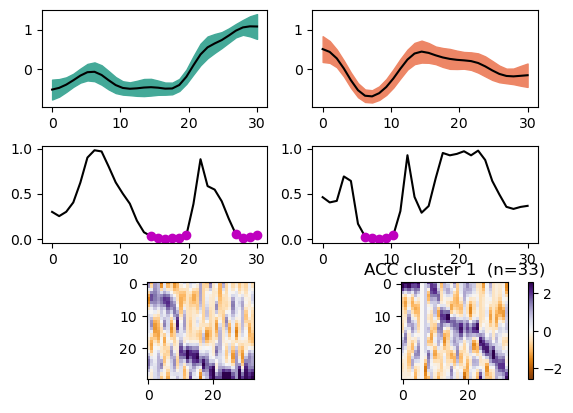

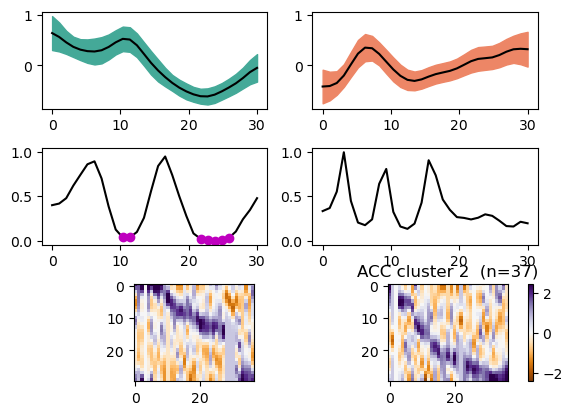

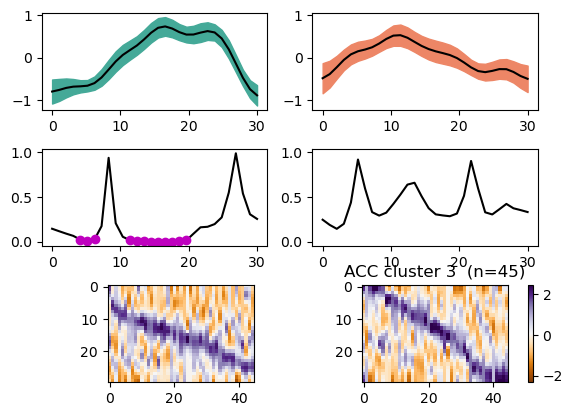

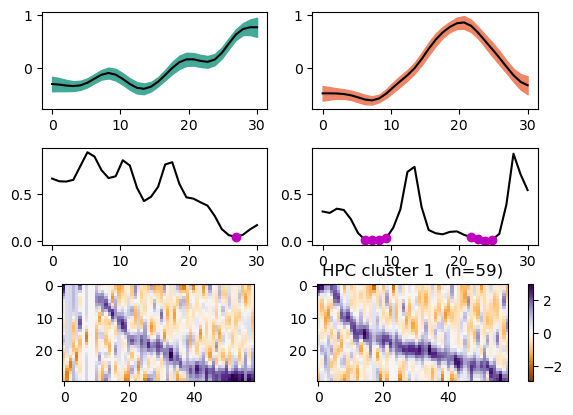

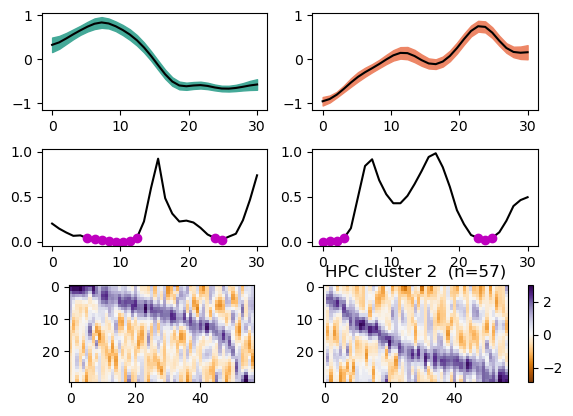

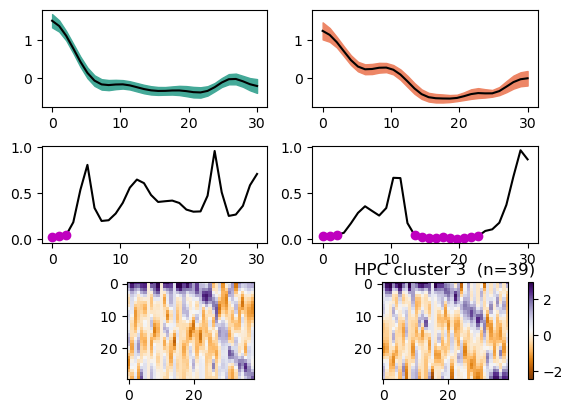

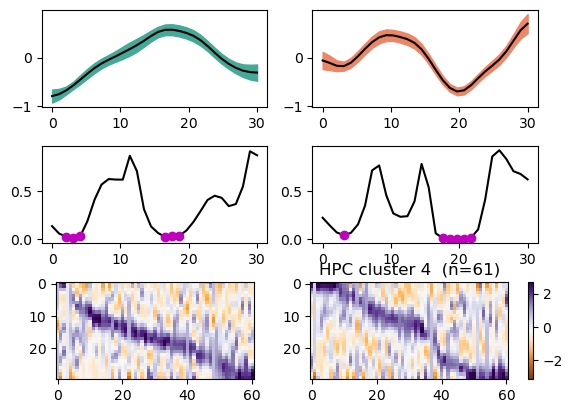

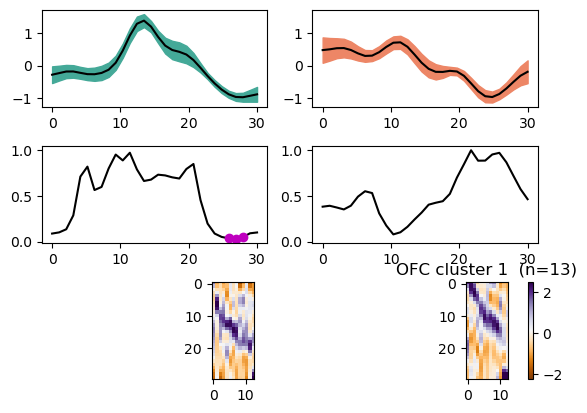

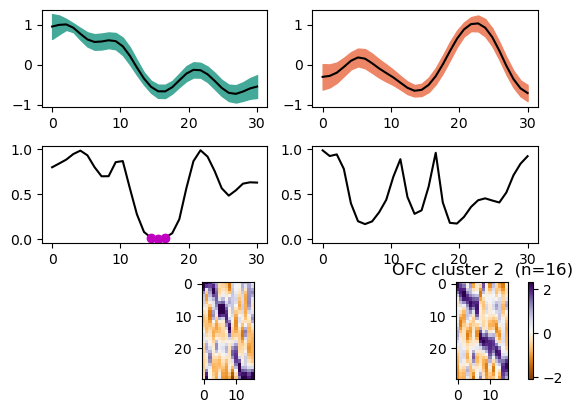

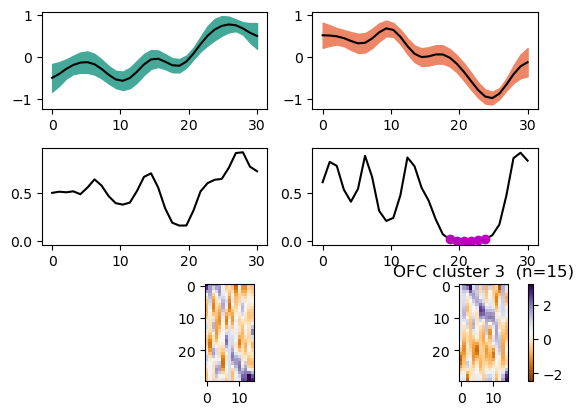

In [10]:
# fix global seed once for LDS + perms
np.random.seed(0)


def _compute_perm_pvals(region_full, labels, cluster_id,
                        nperms, time_points, n_switch, ax_idx, rng):
    """
    Permutation p-values for one region (ACC/HPC), one direction, one cluster.

    region_full[ax_idx] : (n_windows, n_neurons_kept, n_time)
      first n_switch rows  = switch windows
      last  n_switch rows  = control windows
    labels               : (n_neurons_kept,)
    """

    mask = (labels == cluster_id)

    # switch vs control, averaged over neurons in cluster
    sw = region_full[ax_idx][:n_switch, mask, :].mean(axis=1)   # (n_switch, T)
    ct = region_full[ax_idx][n_switch:, mask, :].mean(axis=1)   # (n_switch, T)

    true_diff = sw.mean(axis=0) - ct.mean(axis=0)               # (T,)

    perm_stat = np.zeros((nperms, time_points))
    for t in range(time_points):
        combo = np.hstack((sw[:, t], ct[:, t]))
        for p in range(nperms):
            perm_combo = rng.permutation(combo)
            perm_sw = perm_combo[:n_switch]
            perm_ct = perm_combo[n_switch:]
            perm_stat[p, t] = (perm_sw - perm_ct).mean()

    # two-sided p-values
    more_extreme = np.abs(perm_stat) >= np.abs(true_diff)[None, :]
    pvals = more_extreme.mean(axis=0)

    return pvals, true_diff, perm_stat



# ---------- main LDS + clustering block ----------
if kwargs['plottype'] == 'ldscluster':

    colors = ['#44A998', '#ED8666']     # dir +1, dir -1
    nperms = 1000
    time_points = 30

    # --- behavior inputs: reldist averaged over subjects for each direction ---
    tmpA, tmpB = [], []
    for key in behavior_aligned.keys():
        beh = behavior_aligned[key][1]
        tmpA.append(np.stack(beh['reldist'][beh['direction'] == 1]).mean(axis=0))
        tmpB.append(np.stack(beh['reldist'][beh['direction'] == -1]).mean(axis=0))

    scaler = StandardScaler()
    inputs = [
        np.stack(tmpA).mean(axis=0),
        np.stack(tmpB).mean(axis=0)
    ]

    # --- organize neural windows: deterministic, sep_directions=True ---
    X_train, X_test, Y_train, Y_test = organize_when_decoding(
        neural_aligned, cfgparams,
        sep_directions=True,
        resample_prop=1.0,
        train_test=1.0
    )

    # ------------------------------------------------------------------
    # Split into ACC / HPC / OFC and drop silent neurons
    # ------------------------------------------------------------------
    acc_full, hpc_full, ofc_full = [], [], []
    acc_tmp,  hpc_tmp,  ofc_tmp  = [], [], []

    acc_idx_all = np.where(areas == 'acc')[0]
    hpc_idx_all = np.where(areas == 'hpc')[0]
    ofc_idx_all = np.where(areas == 'ofc')[0]

    for key in X_train.keys():  # '1' and '-1'
        arr = X_train[key]  # (2*n_switch_total, n_neurons_all, T)

        # ACC
        acc_full.append(arr[:, acc_idx_all, :])
        acc_tmp.append(acc_full[-1].copy())

        # HPC
        hpc_full.append(arr[:, hpc_idx_all, :])
        hpc_tmp.append(hpc_full[-1].copy())

        # OFC
        ofc_full.append(arr[:, ofc_idx_all, :])
        ofc_tmp.append(ofc_full[-1].copy())

    # keep neurons that fire in at least one direction
    acc_keep = ((acc_tmp[0].mean(axis=0).sum(axis=1) > 0) |
                (acc_tmp[1].mean(axis=0).sum(axis=1) > 0))
    hpc_keep = ((hpc_tmp[0].mean(axis=0).sum(axis=1) > 0) |
                (hpc_tmp[1].mean(axis=0).sum(axis=1) > 0))
    ofc_keep = ((ofc_tmp[0].mean(axis=0).sum(axis=1) > 0) |
                (ofc_tmp[1].mean(axis=0).sum(axis=1) > 0))

    acc_full = [arr[:, acc_keep, :] for arr in acc_full]
    hpc_full = [arr[:, hpc_keep, :] for arr in hpc_full]
    ofc_full = [arr[:, ofc_keep, :] for arr in ofc_full]

    # by construction: X_train[dir] = [switch windows, control windows]
    n_switch = acc_full[0].shape[0] // 2  # same for all regions

    # ------------------------------------------------------------------
    # Emissions: average switch windows only, then z-score across time
    # ------------------------------------------------------------------
    emissions_train_acc = [
        scaler.fit_transform(acc_full[0][:n_switch, :, :].mean(axis=0).T),
        scaler.fit_transform(acc_full[1][:n_switch, :, :].mean(axis=0).T)
    ]  # each: (T, N_acc)

    emissions_train_hpc = [
        scaler.fit_transform(hpc_full[0][:n_switch, :, :].mean(axis=0).T),
        scaler.fit_transform(hpc_full[1][:n_switch, :, :].mean(axis=0).T)
    ]  # each: (T, N_hpc)

    # only compute OFC emissions if we actually have OFC neurons
    have_ofc = (ofc_full[0].shape[1] > 0)
    if have_ofc:
        emissions_train_ofc = [
            scaler.fit_transform(ofc_full[0][:n_switch, :, :].mean(axis=0).T),
            scaler.fit_transform(ofc_full[1][:n_switch, :, :].mean(axis=0).T)
        ]  # each: (T, N_ofc)

    # ------------------------------------------------------------------
    # Fit LDS models
    # ------------------------------------------------------------------
    # ACC
    lds_acc = ssm.LDS(emissions_train_acc[0].shape[1], 3, M=1, emissions="gaussian")
    elbos_acc, q_acc = lds_acc.fit(
        emissions_train_acc, inputs,
        method="bbvi",
        variational_posterior="meanfield",
        num_iters=3000
    )

    # HPC
    lds_hpc = ssm.LDS(emissions_train_hpc[0].shape[1], 3, M=1, emissions="gaussian")
    elbos_hpc, q_hpc = lds_hpc.fit(
        emissions_train_hpc, inputs,
        method="bbvi",
        variational_posterior="meanfield",
        num_iters=3000
    )

    # OFC (if present)
    if have_ofc:
        lds_ofc = ssm.LDS(emissions_train_ofc[0].shape[1], 3, M=1, emissions="gaussian")
        elbos_ofc, q_ofc = lds_ofc.fit(
            emissions_train_ofc, inputs,
            method="bbvi",
            variational_posterior="meanfield",
            num_iters=3000
        )

    rng_perm = np.random.RandomState(123)

    # ------------------------------------------------------------------
    # ---------- ACC: whitening, auto-k clustering, permutation tests ----------
    # ------------------------------------------------------------------
    if kwargs['dowhiten']:
        C = lds_acc.emissions.params[0].squeeze()
        x1, x2 = q_acc.mean[0], q_acc.mean[1]
        _, _, _, C_prime = proc.lds_whitening_transform(x1, x2, C)
        embed_acc = C_prime
    else:
        embed_acc = lds_acc.emissions.params[0].squeeze()

    n_clusters_acc = choose_k_with_sil_db(
        embed_acc,
        k_range=(2, 3, 4, 5),
        min_cluster_size=10,
        top_n=2,
        random_state=10
    )
    labels_acc = KMeans(n_clusters=n_clusters_acc, n_init=10,
                        random_state=50).fit_predict(embed_acc.squeeze())

    z_score_acc_dict = {}
    summary_acc = {}

    for cl in np.unique(labels_acc):

        fig, axes = plt.subplots(nrows=3, ncols=2,
                                 gridspec_kw={'hspace': 0.4},
                                 sharey=False)

        mask = (labels_acc == cl)

        # global color limits across directions
        vmin = min([
            gf(scaler.fit_transform(
                (acc_full[ax][:n_switch, mask, :] -
                 acc_full[ax][n_switch:, mask, :]).mean(axis=0).T),
               sigma=0.5).min()
            for ax in range(2)
        ])
        vmax = max([
            gf(scaler.fit_transform(
                (acc_full[ax][:n_switch, mask, :] -
                 acc_full[ax][n_switch:, mask, :]).mean(axis=0).T),
               sigma=0.5).max()
            for ax in range(2)
        ])

        summary_acc[cl] = {
            'n_neurons': int(mask.sum()),
            'min_p_dir0': None, 'min_p_dir1': None,
            'min_p_time_dir0': None, 'min_p_time_dir1': None
        }

        for ax_idx in range(2):  # 0: dir+1, 1: dir-1

            pvals, true_diff, perm_stat = _compute_perm_pvals(
                acc_full, labels_acc, cl,
                nperms, time_points, n_switch,
                ax_idx, rng_perm
            )

            z_score_acc_dict.setdefault(cl, {})[ax_idx] = pvals.copy()

            if ax_idx == 0:
                summary_acc[cl]['min_p_dir0']      = float(pvals.min())
                summary_acc[cl]['min_p_time_dir0'] = int(np.argmin(pvals))
            else:
                summary_acc[cl]['min_p_dir1']      = float(pvals.min())
                summary_acc[cl]['min_p_time_dir1'] = int(np.argmin(pvals))

            # mean LDS-embedded activity in this cluster & direction
            mu = emissions_train_acc[ax_idx][:, mask].mean(axis=1)
            # keep original ACC SEM behavior (fixed sqrt(15))
            sd = emissions_train_acc[ax_idx][:, mask].std(axis=1) / np.sqrt(15)
            t = np.linspace(0, time_points, time_points)

            axes[0, ax_idx].fill_between(t, mu - sd, mu + sd, color=colors[ax_idx])
            axes[0, ax_idx].plot(t, mu, 'k')

            # p-values over time (switch vs control)
            axes[1, ax_idx].plot(t, pvals, 'k')
            sig_idx = np.where(pvals < 0.051)[0]
            if sig_idx.size > 0:
                axes[1, ax_idx].plot(t[sig_idx], pvals[sig_idx], 'mo')

            if ax_idx > 0:
                axes[0, ax_idx].sharey(axes[0, 0])
                axes[1, ax_idx].sharey(axes[1, 0])

            # heatmap: switch-control difference per neuron
            diff_map = (acc_full[ax_idx][:n_switch, mask, :] -
                        acc_full[ax_idx][n_switch:, mask, :]).mean(axis=0).T
            diff_map = scaler.fit_transform(diff_map)
            implot = gf(diff_map, sigma=0.7, axis=0)
            peaks = np.argmax(implot, axis=0)
            sort_idx = np.argsort(peaks)
            implot = implot[:, sort_idx]
            implot[implot < 0] *= 0.7
            implot[implot > 0] *= 1.2

            img = axes[2, ax_idx].imshow(implot, vmin=vmin, vmax=vmax, cmap='PuOr')

        fig.colorbar(img, ax=axes[2, :],
                     orientation='vertical', fraction=0.02, pad=0.04)
        fig.tight_layout()
        plt.title(f"ACC cluster {cl + 1}  (n={mask.sum()})")
        plt.show()

    # ------------------------------------------------------------------
    # ---------- HPC: whitening, auto-k, perms ----------
    # ------------------------------------------------------------------
    if kwargs['dowhiten']:
        C = lds_hpc.emissions.params[0].squeeze()
        x1, x2 = q_hpc.mean[0], q_hpc.mean[1]
        _, _, _, C_prime = proc.lds_whitening_transform(x1, x2, C)
        embed_hpc = C_prime
    else:
        embed_hpc = lds_hpc.emissions.params[0].squeeze()

    n_clusters_hpc = choose_k_with_sil_db(
        embed_hpc,
        k_range=(2, 3, 4, 5),
        min_cluster_size=10,
        top_n=2,
        random_state=10
    )
    labels_hpc = KMeans(n_clusters=n_clusters_hpc, n_init=10,
                        random_state=50).fit_predict(embed_hpc.squeeze())

    z_score_hpc_dict = {}
    summary_hpc = {}

    for cl in np.unique(labels_hpc):

        fig, axes = plt.subplots(nrows=3, ncols=2,
                                 gridspec_kw={'hspace': 0.4},
                                 sharey=False)

        mask = (labels_hpc == cl)

        vmin = min([
            gf(scaler.fit_transform(
                (hpc_full[ax][:n_switch, mask, :] -
                 hpc_full[ax][n_switch:, mask, :]).mean(axis=0).T),
               sigma=0.5).min()
            for ax in range(2)
        ])
        vmax = max([
            gf(scaler.fit_transform(
                (hpc_full[ax][:n_switch, mask, :] -
                 hpc_full[ax][n_switch:, mask, :]).mean(axis=0).T),
               sigma=0.5).max()
            for ax in range(2)
        ])

        summary_hpc[cl] = {
            'n_neurons': int(mask.sum()),
            'min_p_dir0': None, 'min_p_dir1': None,
            'min_p_time_dir0': None, 'min_p_time_dir1': None
        }

        for ax_idx in range(2):

            pvals, true_diff, perm_stat = _compute_perm_pvals(
                hpc_full, labels_hpc, cl,
                nperms, time_points, n_switch,
                ax_idx, rng_perm
            )

            z_score_hpc_dict.setdefault(cl, {})[ax_idx] = pvals.copy()

            if ax_idx == 0:
                summary_hpc[cl]['min_p_dir0']      = float(pvals.min())
                summary_hpc[cl]['min_p_time_dir0'] = int(np.argmin(pvals))
            else:
                summary_hpc[cl]['min_p_dir1']      = float(pvals.min())
                summary_hpc[cl]['min_p_time_dir1'] = int(np.argmin(pvals))

            mu = emissions_train_hpc[ax_idx][:, mask].mean(axis=1)
            # HPC SEM = cluster-size–based
            sd = emissions_train_hpc[ax_idx][:, mask].std(axis=1) / np.sqrt(mask.sum())
            t = np.linspace(0, time_points, time_points)

            axes[0, ax_idx].fill_between(t, mu - sd, mu + sd, color=colors[ax_idx])
            axes[0, ax_idx].plot(t, mu, 'k')

            axes[1, ax_idx].plot(t, pvals, 'k')
            sig_idx = np.where(pvals < 0.051)[0]
            if sig_idx.size > 0:
                axes[1, ax_idx].plot(t[sig_idx], pvals[sig_idx], 'mo')

            if ax_idx > 0:
                axes[0, ax_idx].sharey(axes[0, 0])
                axes[1, ax_idx].sharey(axes[1, 0])

            diff_map = (hpc_full[ax_idx][:n_switch, mask, :] -
                        hpc_full[ax_idx][n_switch:, mask, :]).mean(axis=0).T
            diff_map = scaler.fit_transform(diff_map)
            implot = gf(diff_map, sigma=0.7, axis=0)
            peaks = np.argmax(implot, axis=0)
            sort_idx = np.argsort(peaks)
            implot = implot[:, sort_idx]
            implot[implot < 0] *= 0.7
            implot[implot > 0] *= 1.2

            img = axes[2, ax_idx].imshow(implot, vmin=vmin, vmax=vmax, cmap='PuOr')

        fig.colorbar(img, ax=axes[2, :],
                     orientation='vertical', fraction=0.02, pad=0.04)
        fig.tight_layout()
        plt.title(f"HPC cluster {cl + 1}  (n={mask.sum()})")
        plt.show()

    # ------------------------------------------------------------------
    # ---------- OFC: whitening, auto-k, perms (if any OFC neurons) ----------
    # ------------------------------------------------------------------
    if have_ofc:

        if kwargs['dowhiten']:
            C = lds_ofc.emissions.params[0].squeeze()
            x1, x2 = q_ofc.mean[0], q_ofc.mean[1]
            _, _, _, C_prime = proc.lds_whitening_transform(x1, x2, C)
            embed_ofc = C_prime
        else:
            embed_ofc = lds_ofc.emissions.params[0].squeeze()

        n_clusters_ofc = choose_k_with_sil_db(
            embed_ofc,
            k_range=(2, 3, 4, 5),
            min_cluster_size=10,
            top_n=2,
            random_state=10
        )
        labels_ofc = KMeans(n_clusters=n_clusters_ofc, n_init=10,
                            random_state=50).fit_predict(embed_ofc.squeeze())

        z_score_ofc_dict = {}
        summary_ofc = {}

        for cl in np.unique(labels_ofc):

            fig, axes = plt.subplots(nrows=3, ncols=2,
                                     gridspec_kw={'hspace': 0.4},
                                     sharey=False)

            mask = (labels_ofc == cl)

            vmin = min([
                gf(scaler.fit_transform(
                    (ofc_full[ax][:n_switch, mask, :] -
                     ofc_full[ax][n_switch:, mask, :]).mean(axis=0).T),
                   sigma=0.5).min()
                for ax in range(2)
            ])
            vmax = max([
                gf(scaler.fit_transform(
                    (ofc_full[ax][:n_switch, mask, :] -
                     ofc_full[ax][n_switch:, mask, :]).mean(axis=0).T),
                   sigma=0.5).max()
                for ax in range(2)
            ])

            summary_ofc[cl] = {
                'n_neurons': int(mask.sum()),
                'min_p_dir0': None, 'min_p_dir1': None,
                'min_p_time_dir0': None, 'min_p_time_dir1': None
            }

            for ax_idx in range(2):

                pvals, true_diff, perm_stat = _compute_perm_pvals(
                    ofc_full, labels_ofc, cl,
                    nperms, time_points, n_switch,
                    ax_idx, rng_perm
                )

                z_score_ofc_dict.setdefault(cl, {})[ax_idx] = pvals.copy()

                if ax_idx == 0:
                    summary_ofc[cl]['min_p_dir0']      = float(pvals.min())
                    summary_ofc[cl]['min_p_time_dir0'] = int(np.argmin(pvals))
                else:
                    summary_ofc[cl]['min_p_dir1']      = float(pvals.min())
                    summary_ofc[cl]['min_p_time_dir1'] = int(np.argmin(pvals))

                mu = emissions_train_ofc[ax_idx][:, mask].mean(axis=1)
                sd = emissions_train_ofc[ax_idx][:, mask].std(axis=1) / np.sqrt(mask.sum())
                t = np.linspace(0, time_points, time_points)

                axes[0, ax_idx].fill_between(t, mu - sd, mu + sd, color=colors[ax_idx])
                axes[0, ax_idx].plot(t, mu, 'k')

                axes[1, ax_idx].plot(t, pvals, 'k')
                sig_idx = np.where(pvals < 0.051)[0]
                if sig_idx.size > 0:
                    axes[1, ax_idx].plot(t[sig_idx], pvals[sig_idx], 'mo')

                if ax_idx > 0:
                    axes[0, ax_idx].sharey(axes[0, 0])
                    axes[1, ax_idx].sharey(axes[1, 0])

                diff_map = (ofc_full[ax_idx][:n_switch, mask, :] -
                            ofc_full[ax_idx][n_switch:, mask, :]).mean(axis=0).T
                diff_map = scaler.fit_transform(diff_map)
                implot = gf(diff_map, sigma=0.7, axis=0)
                peaks = np.argmax(implot, axis=0)
                sort_idx = np.argsort(peaks)
                implot = implot[:, sort_idx]
                implot[implot < 0] *= 0.7
                implot[implot > 0] *= 1.2

                img = axes[2, ax_idx].imshow(implot, vmin=vmin, vmax=vmax, cmap='PuOr')

            fig.colorbar(img, ax=axes[2, :],
                         orientation='vertical', fraction=0.02, pad=0.04)
            fig.tight_layout()
            plt.title(f"OFC cluster {cl + 1}  (n={mask.sum()})")
            plt.show()



=== ACC ===
Overall silhouette: 0.275
  Cluster 1: mean silhouette = 0.291
  Cluster 2: mean silhouette = 0.267
  Cluster 3: mean silhouette = 0.269


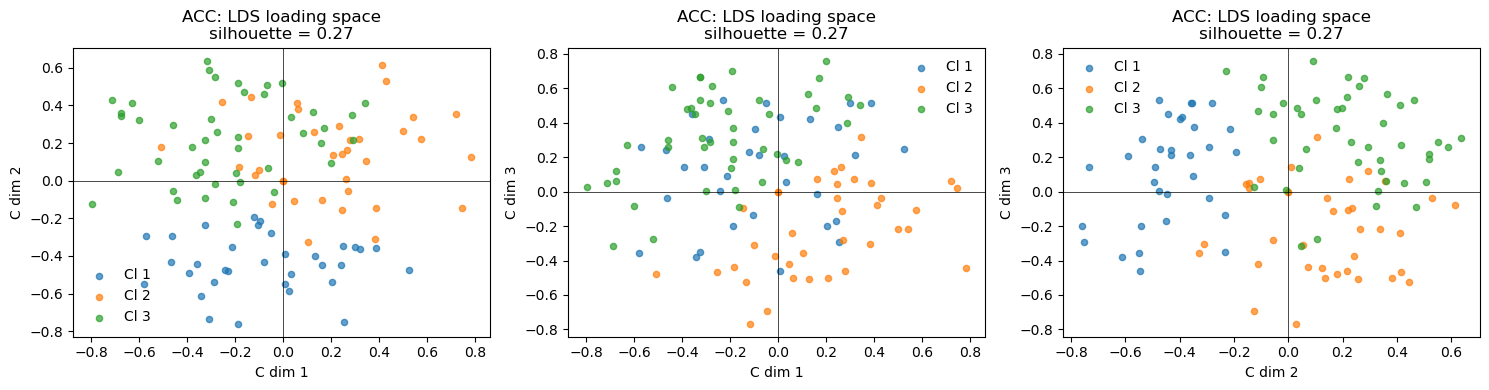


=== HPC ===
Overall silhouette: 0.264
  Cluster 1: mean silhouette = 0.272
  Cluster 2: mean silhouette = 0.267
  Cluster 3: mean silhouette = 0.261
  Cluster 4: mean silhouette = 0.256


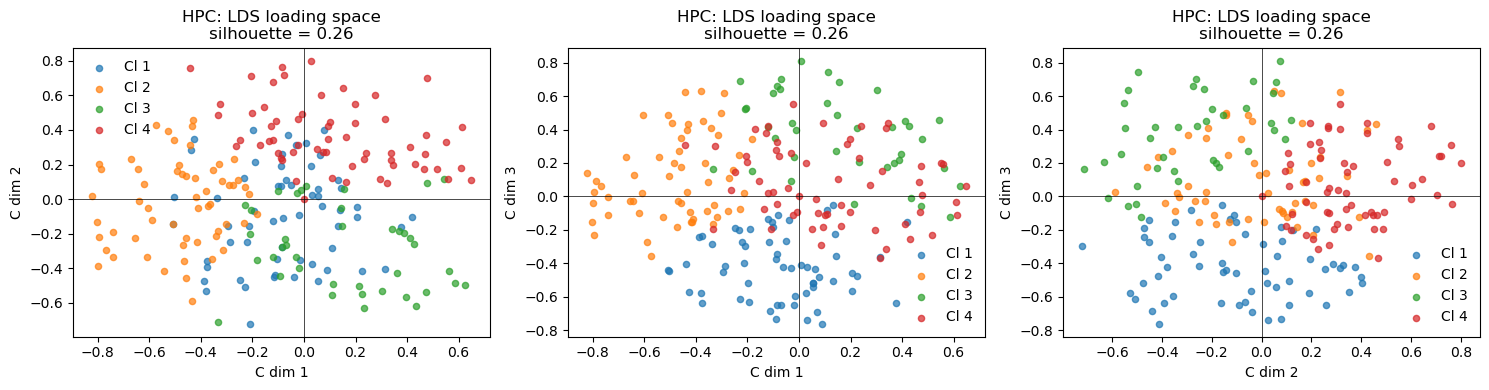


=== OFC ===
Overall silhouette: 0.333
  Cluster 1: mean silhouette = 0.273
  Cluster 2: mean silhouette = 0.366
  Cluster 3: mean silhouette = 0.351


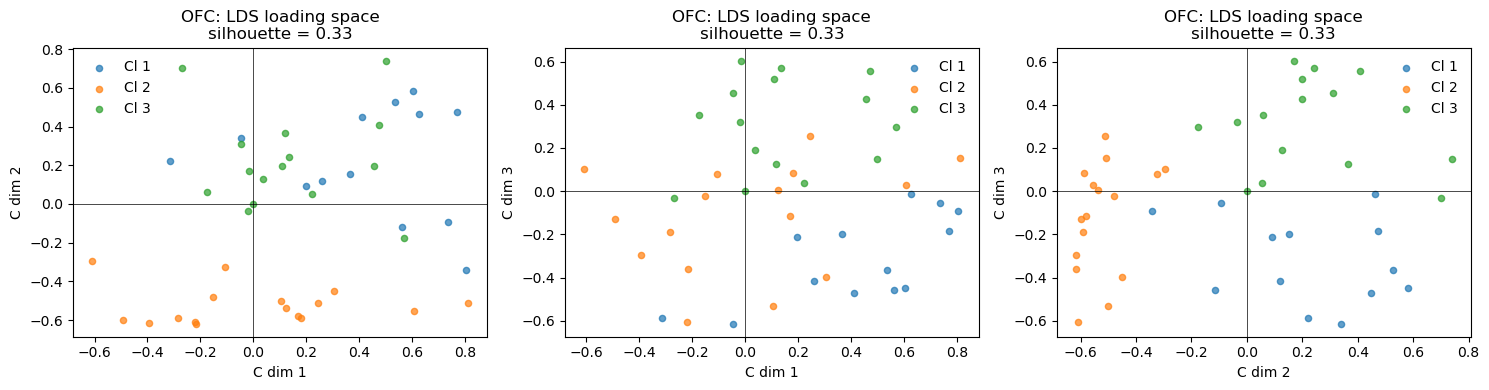

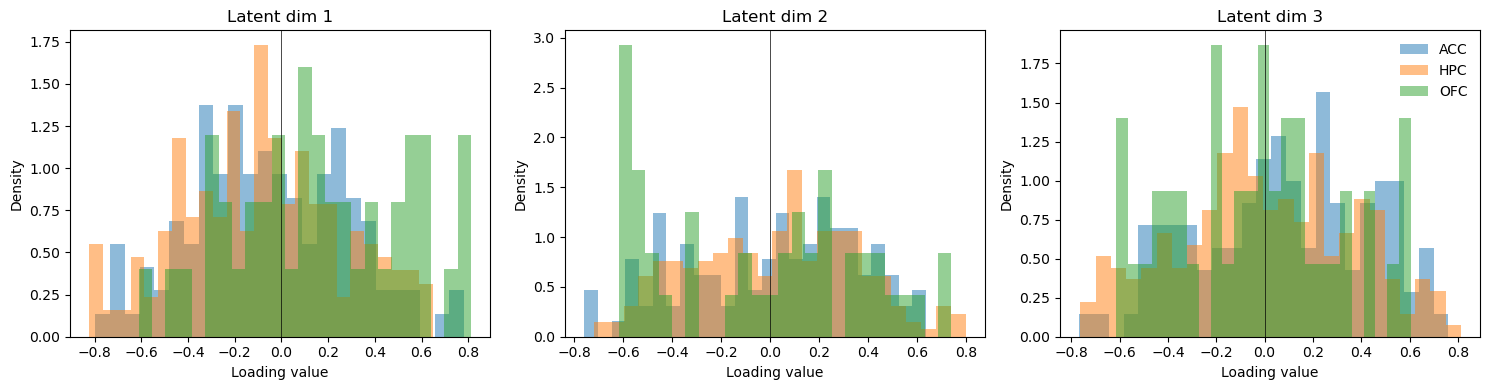

In [12]:
# ===============================================================
#   LDS Loading Scatter Plots (C) + Cross-Region Comparison
#   Plots 2D projections of the emission matrix C for ACC/HPC/OFC
#   Colors = KMeans cluster labels + silhouette scores
# ===============================================================

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples  # NEW

def plot_C_scatter(embed, labels, region, dims=(0,1), ax=None, sil_overall=None):
    """
    embed  : ndarray (N_neurons, 3)   -> the C matrix (whitened or raw)
    labels : ndarray (N_neurons,)     -> cluster labels
    region : string
    dims   : tuple with two dims to plot
    sil_overall : float or None, overall silhouette score to show in title
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    d1, d2 = dims
    for cl in np.unique(labels):
        mask = labels == cl
        ax.scatter(embed[mask, d1], embed[mask, d2],
                   s=20, alpha=0.7, label=f"Cl {cl+1}")

    ax.axhline(0, lw=0.5, color='k')
    ax.axvline(0, lw=0.5, color='k')

    ax.set_xlabel(f"C dim {d1+1}")
    ax.set_ylabel(f"C dim {d2+1}")

    if sil_overall is not None:
        ax.set_title(f"{region}: LDS loading space\nsilhouette = {sil_overall:.2f}")
    else:
        ax.set_title(f"{region}: LDS loading space")

    ax.legend(frameon=False)


# ---------------------------------------------------------------
# 1. 2D SCATTERS + SILHOUETTE FOR EACH REGION
# ---------------------------------------------------------------
regions = [
    ('ACC', embed_acc, labels_acc),
    ('HPC', embed_hpc, labels_hpc),
]

if have_ofc:
    regions.append(('OFC', embed_ofc, labels_ofc))

dims_to_plot = [(0,1), (0,2), (1,2)]

silhouette_summary = {}  # NEW: store scores for printing

for region_name, embed, labels in regions:
    # overall silhouette for this region
    sil_overall = silhouette_score(embed, labels)
    sil_samples = silhouette_samples(embed, labels)

    silhouette_summary[region_name] = {
        'overall': sil_overall,
        'per_cluster': {
            int(cl): sil_samples[labels == cl].mean()
            for cl in np.unique(labels)
        }
    }

    print(f"\n=== {region_name} ===")
    print(f"Overall silhouette: {sil_overall:.3f}")
    for cl, val in silhouette_summary[region_name]['per_cluster'].items():
        print(f"  Cluster {cl+1}: mean silhouette = {val:.3f}")

    # scatter plots with silhouette in the title
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    for i, dims in enumerate(dims_to_plot):
        plot_C_scatter(embed, labels, region_name,
                       dims=dims, ax=axes[i],
                       sil_overall=sil_overall)

    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------
# 2. OPTION C: CROSS-REGION COMPARISON OF LOADING DISTRIBUTIONS
# ---------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15,4))
dim_names = ["Latent dim 1", "Latent dim 2", "Latent dim 3"]

region_embeds = {"ACC": embed_acc, "HPC": embed_hpc}
if have_ofc:
    region_embeds["OFC"] = embed_ofc

for d in range(3):
    ax = axes[d]
    for region_name, embed in region_embeds.items():
        ax.hist(embed[:, d], bins=25, alpha=0.5, density=True, label=region_name)
    ax.axvline(0, lw=0.5, color='k')
    ax.set_title(dim_names[d])
    ax.set_xlabel("Loading value")
    ax.set_ylabel("Density")

axes[-1].legend(frameon=False)
plt.tight_layout()
plt.show()


In [5]:
import os, pickle, time
import numpy as np
from scipy.io import savemat

# ---- config
save_dir = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/Kmeans/new"
os.makedirs(save_dir, exist_ok=True)

# sanity checks (fail early if something is missing)
required = {
    "emissions_train_acc": "T x N_acc kept per dir",
    "labels_acc": "N_acc kept",
    "emissions_train_hpc": "T x N_hpc kept per dir",
    "labels_hpc": "N_hpc kept",
    "time_points": "int",
}
for var in required:
    if var not in globals():
        raise RuntimeError(f"Missing '{var}' ({required[var]}).")

# build time vector for plotting
t = np.linspace(0, int(time_points), int(time_points))

# choose colors (your last overlay call used these)
colors = ('#ED8666', '#44A998')   # (dir -1, dir +1) per your example
auto_flip = False

# pack payloads
meta = {
    "saved_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "script": "ldscluster overlay export",
    "auto_flip_default": auto_flip,
}

acc_payload = dict(
    region="ACC",
    emissions_train=emissions_train_acc,  # list of 2 arrays: [dir+1, dir-1], each (T, N_acc)
    labels=np.asarray(labels_acc),
    time=t,
    time_points=int(time_points),
    colors=np.array(colors, dtype=object),
    meta=meta,
)

hpc_payload = dict(
    region="HPC",
    emissions_train=emissions_train_hpc,  # list of 2 arrays: [dir+1, dir-1], each (T, N_hpc)
    labels=np.asarray(labels_hpc),
    time=t,
    time_points=int(time_points),
    colors=np.array(colors, dtype=object),
    meta=meta,
)

ofc_payload = dict(
    region="OFC",
    emissions_train=emissions_train_ofc,  # list of 2 arrays: [dir+1, dir-1], each (T, N_hpc)
    labels=np.asarray(labels_ofc),
    time=t,
    time_points=int(time_points),
    colors=np.array(colors, dtype=object),
    meta=meta,
)
# filenames with timestamp
stamp = time.strftime("%Y%m%d_%H%M%S")
# acc_pkl = os.path.join(save_dir, f"acc_ldscluster_overlay_{stamp}.pkl")
# hpc_pkl = os.path.join(save_dir, f"hpc_ldscluster_overlay_{stamp}.pkl")
acc_mat = os.path.join(save_dir, f"acc_ldscluster_overlay_{stamp}.mat")
hpc_mat = os.path.join(save_dir, f"hpc_ldscluster_overlay_{stamp}.mat")
ofc_mat = os.path.join(save_dir, f"ofc_ldscluster_overlay_{stamp}.mat")

# # ---- save as PKL
# with open(acc_pkl, "wb") as f:
#     pickle.dump(acc_payload, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open(hpc_pkl, "wb") as f:
#     pickle.dump(hpc_payload, f, protocol=pickle.HIGHEST_PROTOCOL)

# ---- save as MAT
# MATLAB can’t store Python objects; convert lists to dict-of-arrays
acc_matdict = {
    "region": acc_payload["region"],
    "emissions_dir_pos": np.asarray(emissions_train_acc[0]),  # (T, N_acc)
    "emissions_dir_neg": np.asarray(emissions_train_acc[1]),  # (T, N_acc)
    "labels": np.asarray(labels_acc),
    "time": t,
    "time_points": int(time_points),
    "colors": np.asarray(colors, dtype=object),  # MATLAB reads as cellstr
    "meta_saved_at": meta["saved_at"],
}
hpc_matdict = {
    "region": hpc_payload["region"],
    "emissions_dir_pos": np.asarray(emissions_train_hpc[0]),  # (T, N_hpc)
    "emissions_dir_neg": np.asarray(emissions_train_hpc[1]),  # (T, N_hpc)
    "labels": np.asarray(labels_hpc),
    "time": t,
    "time_points": int(time_points),
    "colors": np.asarray(colors, dtype=object),
    "meta_saved_at": meta["saved_at"],
}

ofc_matdict = {
    "region": hpc_payload["region"],
    "emissions_dir_pos": np.asarray(emissions_train_ofc[0]),  # (T, N_hpc)
    "emissions_dir_neg": np.asarray(emissions_train_ofc[1]),  # (T, N_hpc)
    "labels": np.asarray(labels_ofc),
    "time": t,
    "time_points": int(time_points),
    "colors": np.asarray(colors, dtype=object),
    "meta_saved_at": meta["saved_at"],
}
savemat(acc_mat, acc_matdict, do_compression=True)
savemat(hpc_mat, hpc_matdict, do_compression=True)
savemat(ofc_mat, ofc_matdict, do_compression=True)

print("Saved:")
print("  ", acc_mat)
print("  ", hpc_mat)
print("  ", ofc_mat)


Saved:
   /Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/Kmeans/new/acc_ldscluster_overlay_20251209_094217.mat
   /Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/Kmeans/new/hpc_ldscluster_overlay_20251209_094217.mat
   /Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/Kmeans/new/ofc_ldscluster_overlay_20251209_094217.mat
